In [1]:
from astropy.io import fits
import h5py
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pymaster as nmt
import sacc

# Measure galaxy clustering in Fourier space with Namaster

## Load maps that TXPipe outputs

In [27]:
path_outputs = '/global/cscratch1/sd/jprat/TXPipe/data/gaussian_sims/outputs_gaussian_sims/gaussian_sims_srdnzs_fullsky/022422/12300area/2022/March2/'
mask_path = '/global/projecta/projectdirs/lsst/groups/WL/users/jprat/gaussian_sims_srdnzs_fullsky/022422/12300area/TXPipe_inputs/mask.hdf5'

density_maps = h5py.File(path_outputs + 'density_maps.hdf5', 'r')
noise_maps = h5py.File(path_outputs + 'lens_noise_maps.hdf5', 'r')
mask_hdf5 = h5py.File(mask_path, 'r')

## Set ell binning and nside

In [7]:
ell_min = 100
ell_max = 3*nside
n_ell = 30
ell_spacing = "log"

#taken from TXPipe to match exactly
ell_ini = [ 100,  115,  132,  153,  176,  203,  234,  270,  311,  358,  413,
        476,  549,  633,  730,  841,  969, 1117, 1288, 1485, 1711, 1972,
       2273, 2620, 3020, 3481, 4012, 4624, 5330]
ell_end = [115,  132,  153,  176,  203,  234,  270,  311,  358,  413,
        476,  549,  633,  730,  841,  969, 1117, 1288, 1485, 1711, 1972,
       2273, 2620, 3020, 3481, 4012, 4624, 5330, 6144]

ell_bins = nmt.NmtBin.from_edges(ell_ini, ell_end, is_Dell=False)
ls = ell_bins.get_effective_ells()

## Prepare density maps in Namaster format

In [8]:
def read_map(pixel, value):
    npix = hp.nside2npix(nside)
    map = np.zeros(npix)
    map[pix] = value
    return map

In [9]:
nbin_lens = density_maps.file["maps"].attrs["nbin_lens"]
density_field = {}
for i in range(nbin_lens):
    pixel = density_maps['maps/delta_%d/pixel'%i][:]
    value = density_maps['maps/delta_%d/value'%i][:]
    d_map0 = read_map(pixel, value)
    density_field['bin%d'%i] = (nmt.NmtField(mask, [d_map0], n_iter=0))


## Compute measurements using Namaster: this cell below takes a while

In [10]:
c = {}
for i in range(nbin_lens):
    c['bin%d'%i] = nmt.compute_full_master(
                        density_field['bin%d'%i],
                        density_field['bin%d'%i],
                        ell_bins,
                        n_iter=1,
                    )

In [20]:
c

{'bin0': array([[3.99761805e-07, 2.93752969e-07, 2.52809498e-07, 2.15965136e-07,
         1.80422658e-07, 1.58439028e-07, 1.36626066e-07, 1.18560855e-07,
         1.05131432e-07, 9.31065202e-08, 8.48146261e-08, 7.86932725e-08,
         7.31411909e-08, 6.80576331e-08, 6.45489355e-08, 5.99638320e-08,
         5.61980250e-08, 5.35769114e-08, 5.05683947e-08, 4.85158166e-08,
         4.63559611e-08, 4.46977113e-08, 4.30770375e-08, 4.17194143e-08,
         4.05821798e-08, 3.98365678e-08, 3.91857987e-08, 3.87034527e-08,
         3.84976770e-08]]),
 'bin1': array([[3.54307248e-07, 2.37910991e-07, 2.08516890e-07, 1.70818242e-07,
         1.54971677e-07, 1.22736682e-07, 1.07664463e-07, 9.05351615e-08,
         7.94438731e-08, 6.93919617e-08, 6.34830569e-08, 5.59361460e-08,
         5.17354422e-08, 4.73475585e-08, 4.46918898e-08, 4.16273655e-08,
         3.96621013e-08, 3.77233656e-08, 3.62609661e-08, 3.47153529e-08,
         3.35618133e-08, 3.22728812e-08, 3.14737617e-08, 3.05015226e-08,
       

## Subtract the noise from the measurements and correct for beam 

### First load TXPipe's measurement file with the noise we will subtract

In [28]:
dir = '../data_vectors/gaussian_sims/022422/area12300/March2/new_scales/'
file = 'analytic_noise/twopoint_data_fourier_shot_noise_scaled.sacc' #scaled coupled noise
# it's the one above copied from local.
a = sacc.Sacc.load_fits('/global/cscratch1/sd/jprat/twopoint_data_fourier_shot_noise_scaled.sacc')
a_name = 'analytic'

In [29]:
def window_pixel(ell, nside):
            r_theta = 1 / (np.sqrt(3.0) * nside)
            x = ell * r_theta
            f = 0.532 + 0.006 * (x - 0.5) ** 2
            y = f * x
            return np.exp(-(y**2) / 2)

def arcmin2_to_rad2(density):
    return density*60**2*41253/(4*np.pi)
lens_density = np.array([2.2512824191217113, 3.1115067729648382, 3.08574032321282, 2.6049633670894528, 2.002980579933056])
lens_density_rad = arcmin2_to_rad2(lens_density)
cl = {}
for i in range(5):
    n_ell_analytic = a.get_tag('n_ell', data_type="galaxy_density_cl", tracers=('lens_%s'%(i),'lens_%s'%(i)) )
    #cl['bin%d'%i] = (c['bin%d'%i][0]- 1/lens_density_rad[i])/ (window_pixel(ls, nside) ** 2)
    cl['bin%d'%i] = (c['bin%d'%i][0]- n_ell_analytic)/ (window_pixel(ls, nside) ** 2)

## Compare with TXPipe measurements

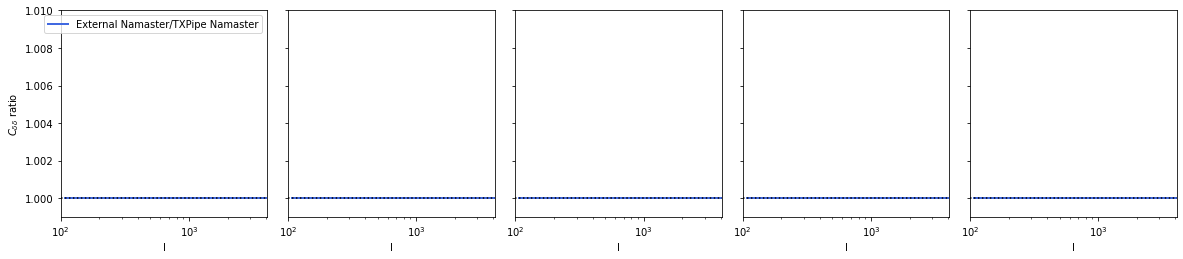

In [25]:
nlbins = 5
fig, ax = plt.subplots(1, nlbins, figsize=(4*nlbins, 4*0.95), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(nlbins):
    ell, cl_txpipe = a.get_ell_cl("galaxy_density_cl",'lens_%s'%(i) , 'lens_%s'%(i))
    ax[i].plot(ls, cl['bin%d'%i]/cl_txpipe, color = 'royalblue', lw = 2, label = 'External Namaster/TXPipe Namaster')
    ax[i].set_xlabel('l')
    ax[i].set_xscale('log')    
    ax[i].axhline(y=1, color = 'k', ls= ':')
    ax[i].set_xlim(100, 2*nside)
    ax[i].set_ylim(0.999, 1.01)

ax[0].set_ylabel(r'$C_{\delta\delta}$ ratio')
ax[0].legend()

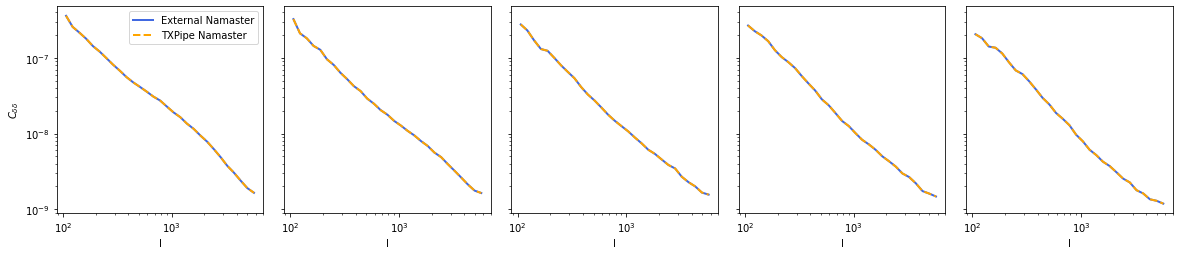

In [24]:
nlbins = 5
fig, ax = plt.subplots(1, nlbins, figsize=(4*nlbins, 4*0.95), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(nlbins):
    ell, cl_txpipe = a.get_ell_cl("galaxy_density_cl",'lens_%s'%(i) , 'lens_%s'%(i))
    ax[i].plot(ls, cl['bin%d'%i], color = 'royalblue', lw = 2, label = 'External Namaster')
    ax[i].plot(ls, cl_txpipe, color = 'orange', ls = '--', lw = 2, label = 'TXPipe Namaster')
    ax[i].set_xlabel('l')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log') 
    #ax[i].axhline(y=1, color = 'k', ls= ':')
    #ax[i].set_xlim(100, 2*nside)
    #ax[i].set_ylim(0.999, 1.025)

ax[0].set_ylabel(r'$C_{\delta\delta}$')
ax[0].legend()

## Extra code that is not needed